In [44]:
#importing necessary libraries
import pandas as pd
import numpy as np
import glob
import os
import warnings
import time
import sys
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
import tensorflow as tf
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import LSTM, Dense, Dropout 
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
# importing custom scripts for different functions
sys.path.append('scripts')  # add scripts to path




# Ignore warnings
warnings.filterwarnings("ignore")

In [45]:
#loading the combined df
combined_df = pd.read_csv("../notebook/combined.csv")

## Exploratory Data Analysis

In [46]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57010 entries, 0 to 57009
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Commodity       57010 non-null  object 
 1   Classification  57010 non-null  object 
 2   Grade           57010 non-null  object 
 3   Sex             57010 non-null  object 
 4   Market          57010 non-null  object 
 5   Wholesale       57010 non-null  object 
 6   Retail          57010 non-null  object 
 7   Supply Volume   39235 non-null  float64
 8   County          56991 non-null  object 
 9   Date            57010 non-null  object 
dtypes: float64(1), object(9)
memory usage: 4.3+ MB


In [47]:
#checking for missing/null values
combined_df.isnull().sum()

Commodity             0
Classification        0
Grade                 0
Sex                   0
Market                0
Wholesale             0
Retail                0
Supply Volume     17775
County               19
Date                  0
dtype: int64

In [48]:
#checking for duplicates
combined_df.duplicated().sum()

np.int64(4259)

In [49]:
#dropping duplicates
combined_df.drop_duplicates(inplace=True)

In [50]:
#grouping data by market and filling missing values in the 'County' column with the mode of the respective market
combined_df['County'] = combined_df.groupby('Market')['County'].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else "Unknown"))

In [51]:
#impute missing values in the supply volume column with the median value of the respective market
combined_df["Supply Volume"] = combined_df["Supply Volume"].fillna(
    combined_df.groupby("Commodity")["Supply Volume"].transform("median")
)

In [52]:
combined_df.isna().sum()

Commodity         0
Classification    0
Grade             0
Sex               0
Market            0
Wholesale         0
Retail            0
Supply Volume     0
County            0
Date              0
dtype: int64

In [53]:
#converting dates into date format using pd.to_datetime
combined_df['Date'] = pd.to_datetime(combined_df['Date'])
combined_df.head()

,Commodity,Classification,Grade,Sex,Market,Wholesale,Retail,Supply Volume,County,Date
0,Banana (Ripening),-,-,-,Mukuyu Market,-,50.00/Kg,1500.0,Muranga,2026-02-11
1,Banana (Ripening),-,-,-,Mulot,70.00/Kg,100.00/Kg,1500.0,Bomet,2026-02-11
2,Banana (Ripening),-,-,-,Kitale Municipality Market,80.00/Kg,100.00/Kg,6000.0,Trans-Nzoia,2026-02-11
3,Banana (Ripening),-,-,-,Kerugoya,20.00/Kg,40.00/Kg,300.0,Kirinyaga,2026-02-10
4,Banana (Ripening),-,-,-,Bondeni,80.00/Kg,100.00/Kg,5000.0,Trans-Nzoia,2026-02-10


In [54]:
#keeping columns that will be used in the model
data = combined_df.drop(columns=['Classification', 'Grade', 'Sex'], axis=1)

In [55]:
#removing 'Kg' and other symbols from the retail and wholesale columns
for col in ['Retail', 'Wholesale']:
    data[col] = (
        data[col]
        .astype(str)
        .str.replace('/Kg', '', regex=False)
        .str.replace('-', '', regex=False)
        .str.strip()
    )

In [56]:
data.head()

,Commodity,Market,Wholesale,Retail,Supply Volume,County,Date
0,Banana (Ripening),Mukuyu Market,,50.00,1500.0,Muranga,2026-02-11
1,Banana (Ripening),Mulot,70.00,100.00,1500.0,Bomet,2026-02-11
2,Banana (Ripening),Kitale Municipality Market,80.00,100.00,6000.0,Trans-Nzoia,2026-02-11
3,Banana (Ripening),Kerugoya,20.00,40.00,300.0,Kirinyaga,2026-02-10
4,Banana (Ripening),Bondeni,80.00,100.00,5000.0,Trans-Nzoia,2026-02-10


In [57]:
#converting the retail and wholesale columns to numeric columns
for col in ['Retail', 'Wholesale']:
    data[col] = pd.to_numeric(data[col], errors='coerce')
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 52751 entries, 0 to 57009
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Commodity      52751 non-null  object        
 1   Market         52751 non-null  object        
 2   Wholesale      41690 non-null  float64       
 3   Retail         50557 non-null  float64       
 4   Supply Volume  52751 non-null  float64       
 5   County         52751 non-null  object        
 6   Date           52751 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(3), object(3)
memory usage: 3.2+ MB


In [58]:
data["Wholesale"] = data["Wholesale"].fillna(0)
data["Retail"] = data["Retail"].fillna(0)

In [59]:
# Calculate absolute price difference
data['Price_Margin'] = data['Retail'] - data['Wholesale']
data = data[data['Wholesale'] > 0].copy()
# Calculate percentage margin, handling division by zero
data['Margin_Percentage'] = (data['Price_Margin'] / data['Wholesale']) * 100

In [60]:
#checking for null values in the new df
data.isnull().sum()

Commodity            0
Market               0
Wholesale            0
Retail               0
Supply Volume        0
County               0
Date                 0
Price_Margin         0
Margin_Percentage    0
dtype: int64

In [61]:
# filling missing values in each group
def clean_price(series):
	clean_series = pd.to_numeric(series.astype(str).str.replace('[^0-9.]', '', regex=True), errors='coerce')
	return clean_series

data["Wholesale"] = clean_price(data["Wholesale"])
data["Retail"] = clean_price(data["Retail"])

In [62]:
data["Commodity"].value_counts()

Commodity
Red Irish potato               2644
Cowpeas                        2619
Dry Maize                      2568
Wheat                          2517
Kales/Sukuma Wiki              2512
Dry Onions                     2511
Finger Millet                  2476
Banana (Cooking)               2476
Cowpea leaves (Kunde)          2467
Beans (Yellow-Green)           2464
Rice                           2460
Beans Red Haricot (Wairimu)    2459
Banana (Ripening)              2445
Spinach                        2438
Cabbages                       2416
Omena                          2281
Meat Beef                      1763
Maize Flour                     164
Red Sorghum                      10
Name: count, dtype: int64

### *Commodities with the highest sales*

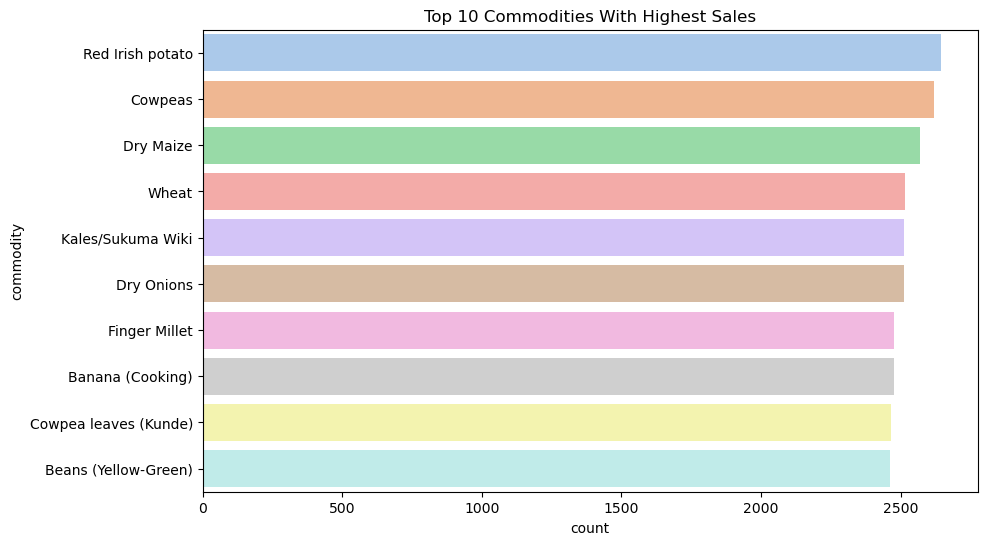

In [63]:
top_10_commodities = (
    data["Commodity"].value_counts().head(10).reset_index()
)
top_10_commodities.columns = ["commodity", 'count']

plt.figure(figsize=(10,6))
sns.barplot(data=top_10_commodities, x ="count", y="commodity",  palette="pastel")
plt.title("Top 10 Commodities With Highest Sales")
plt.show()

Peak in prices occur slightly around January, probably due to dry weather conditions and July,supply around this time is a bit tight as most harvests occur around August-October

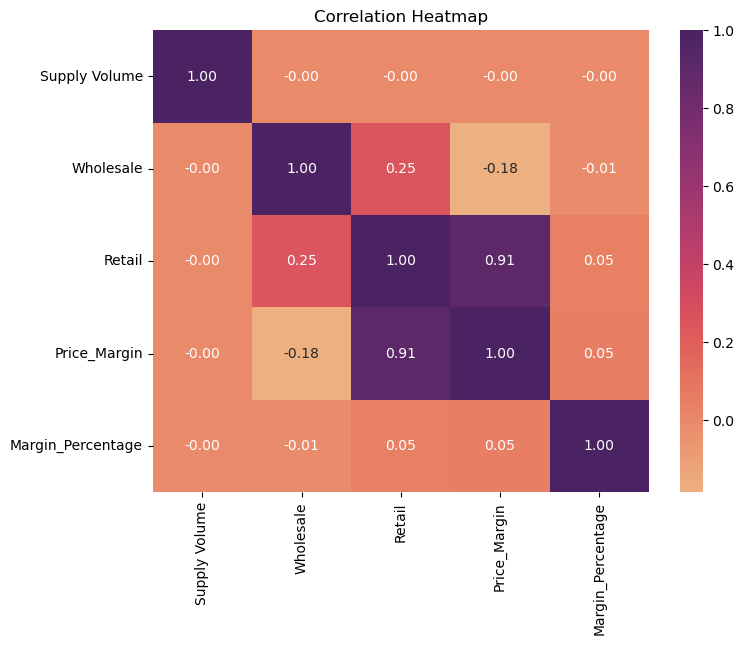

In [64]:
plt.figure(figsize=(8, 6))
correlation = data[["Supply Volume", 'Wholesale', 'Retail', 'Price_Margin', 'Margin_Percentage']].corr()
sns.heatmap(correlation, annot=True, cmap="flare", fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

There are no highly correlated features

## *Modelling*

Implementing SARIMA Model for Wholesale Prices of Various Commodities

#### Feature Engineering

In [65]:
commodities = data["Commodity"].unique()

sarima_results = {}

for commodity, df_c in data.groupby("Commodity"):

    monthly_wholesale_data = (
        df_c.set_index("Date")
        .resample("M")["Wholesale"]
        .mean()
        .interpolate("time")
    )
    if len(monthly_wholesale_data.dropna()) < 24:
        print(f"Skipping {commodity}, not enough data")
        continue # excludes commodities with less than 24 months of data
 
    

Skipping Cabbages, not enough data
Skipping Dry Maize, not enough data
Skipping Dry Onions, not enough data
Skipping Maize Flour, not enough data
Skipping Red Sorghum, not enough data
Skipping Rice, not enough data


Train-test split

In [66]:
train_data_wholesale = monthly_wholesale_data[:-12] # all data before last 12 months
test_data_wholesale = monthly_wholesale_data[-12:] # last 12 months

In [67]:
sarima_model_wholesale = SARIMAX(
        train_data_wholesale, order=(1, 1, 1), 
        seasonal_order=(1, 1, 1, 12),
        enforce_stationarity=False,
        enforce_invertibility=False
    )

results = sarima_model_wholesale.fit(disp=False)
forecast = results.forecast(steps=12)

sarima_results[commodity] = {
                "model": results,
                "test": test_data_wholesale,
                "forecast": forecast
            }

print(f"{commodity} model fitted successfully")
        



Wheat model fitted successfully


Evaluation

In [68]:
mae = mean_absolute_error(test_data_wholesale, forecast)
print("MAE:", mae)

MAE: 7.078819635107403


The mean absolute error fro the SARIMA model of wholesale wheat prices was sh. 7.08 per kg, meaning that on average, the model's price froecast deviated from the actual price by approximately sh.7

In [69]:
rmse = np.sqrt(mean_squared_error(test_data_wholesale, forecast))
print("RMSE:", rmse)

RMSE: 10.041437689193408


SARIMA model for Retail Prices

In [70]:
for commodity, df_c in data.groupby("Commodity"):

    monthly_retail_data = (
        df_c.set_index("Date")
        .resample("M")["Retail"]
        .mean()
        .interpolate("time")
    )
    if len(monthly_wholesale_data.dropna()) < 24:
        print(f"Skipping {commodity}, not enough data")
        continue # excludes commodities with less than 24 months of data

In [71]:
train_data_retail = monthly_retail_data[:-12]
test_data_retail = monthly_retail_data[-12:]  

In [72]:
sarima_retail_results = {}

model_retail = SARIMAX(
    train_data_retail,
    order=(1,1,1),
    seasonal_order=(1,1,1,12),
    enforce_stationarity=False,
    enforce_invertibility=False
)

results_retail = model_retail.fit(disp=False)
forecast_retail = results_retail.forecast(steps=12)

sarima_retail_results[commodity] = {"model": results_retail, "test": test_data_retail, "forecast": forecast_retail}
print(f"{commodity}: model fitted")

Wheat: model fitted


Evaluation

In [73]:
mae_retail = mean_absolute_error(test_data_retail, forecast_retail)
print("MAE:", mae_retail)   

MAE: 24.886158689594115


The SARIMA model for Wheat retail prices has a MAE of 24.998, meaning for every retail price prediction, the forecast is off by about sh.25 per kg of wheat.

### LSTM

In [74]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 41690 entries, 1 to 57009
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Commodity          41690 non-null  object        
 1   Market             41690 non-null  object        
 2   Wholesale          41690 non-null  float64       
 3   Retail             41690 non-null  float64       
 4   Supply Volume      41690 non-null  float64       
 5   County             41690 non-null  object        
 6   Date               41690 non-null  datetime64[ns]
 7   Price_Margin       41690 non-null  float64       
 8   Margin_Percentage  41690 non-null  float64       
dtypes: datetime64[ns](1), float64(5), object(3)
memory usage: 3.2+ MB


In [75]:
#grouping data by commodity, county, and month to get average retail and wholesale prices for each month
monthly_data = data.groupby([
    "Commodity", 
    "County", 
    pd.Grouper(key='Date', freq='MS')
])[["Retail", "Wholesale"]].mean().reset_index()

In [76]:
monthly_data.head()

,Commodity,County,Date,Retail,Wholesale
0,Banana (Cooking),Bomet,2024-04-01,49.285714,31.898571
1,Banana (Cooking),Bomet,2024-05-01,57.857143,37.755714
2,Banana (Cooking),Bomet,2024-06-01,90.000000,62.500000
3,Banana (Cooking),Bomet,2024-07-01,55.000000,12.778333
4,Banana (Cooking),Bomet,2024-08-01,66.250000,46.250000


In [77]:
#scaling the retail and wholesale columns using MinMaxScaler
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(monthly_data[["Retail", "Wholesale"]])


In [78]:
seq_length = 6
X, y = create_sequences(scaled_data, seq_length)

#Train-test split
train_size = int(len(scaled_data) * 0.8) # 80% for training
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [79]:
model = Sequential([LSTM(64, activation="tanh", input_shape=(seq_length, 1)),Dropout(0.2),Dense(1)  
])
model.compile(optimizer='adam', loss='mse')

model = Sequential([
    LSTM(64, activation="tanh", input_shape=(seq_length, 1)),
    Dropout(0.2),
    Dense(1)  
])

model.compile(
    optimizer="adam",
    loss="mse"
)


In [80]:
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

In [81]:
def run_lstm_forecast_dual(monthly_data, seq_length=12, forecast_steps=6):
    commodities = monthly_data["Commodity"].unique()
    targets = [col for col in ["Retail", "Wholesale"] if col in monthly_data.columns]

    results = {}
    models = {}

    for commodity in commodities:
        results[commodity] = {}
        models[commodity] = {}

        df_com = monthly_data[monthly_data["Commodity"] == commodity].copy()
        df_com = df_com.sort_values("Date")

        for target_col in targets:
            values = df_com[target_col].values.reshape(-1, 1)

            effective_seq_length = min(seq_length, max(3, len(values) - forecast_steps))
            if len(values) <= effective_seq_length:
                print(f"Skipping {commodity} ({target_col}) — too few records")
                continue

            scaler = MinMaxScaler()
            scaled = scaler.fit_transform(values)

            X, y = create_sequences(scaled, effective_seq_length)

            train_size = int(len(X) * 0.8)
            X_train, X_test = X[:train_size], X[train_size:]
            y_train, y_test = y[:train_size], y[train_size:]

            X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
            X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

            model = Sequential([
                LSTM(64, activation="tanh", input_shape=(effective_seq_length, 1)),
                Dropout(0.2),
                Dense(1)
            ])
            model.compile(optimizer="adam", loss="mse")

            model.fit(
                X_train, y_train,
                validation_data=(X_test, y_test),
                epochs=30,
                batch_size=16,
                callbacks=[EarlyStopping(monitor="val_loss", patience=5)],
                verbose=0
            )

            y_pred = model.predict(X_test, verbose=0)
            y_pred_rescaled = scaler.inverse_transform(y_pred)
            y_test_rescaled = scaler.inverse_transform(y_test)

            mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
            rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))

            # Forecast
            future_preds = []
            last_seq = X_test[-1]

            for _ in range(forecast_steps):
                pred = model.predict(last_seq.reshape(1, effective_seq_length, 1), verbose=0)
                future_preds.append(pred[0, 0])
                last_seq = np.vstack([last_seq[1:], pred])

            future_rescaled = scaler.inverse_transform(
                np.array(future_preds).reshape(-1, 1)
            )

            results[commodity][target_col] = {
                "MAE": mae,
                "RMSE": rmse,
                "Forecast": future_rescaled.flatten(),
                "LagUsed": effective_seq_length
            }
            models[commodity][target_col] = model

    return results, models

In [82]:
results, models = run_lstm_forecast_dual(
    monthly_data,
    seq_length=3,
    forecast_steps=6
)

for com, res in results.items():
    for target, metrics in res.items():
        print(f"{com} ({target}) → MAE: {metrics['MAE']:.2f}, RMSE: {metrics['RMSE']:.2f}, LagUsed: {metrics['LagUsed']}")
        print(f"Next 6 months forecast: {metrics['Forecast']}\n")

Banana (Cooking) (Retail) → MAE: 52.30, RMSE: 215.29, LagUsed: 3
Next 6 months forecast: [48.444027 48.607273 49.223705 49.782253 49.821953 49.848484]

Banana (Cooking) (Wholesale) → MAE: 30.93, RMSE: 109.12, LagUsed: 3
Next 6 months forecast: [43.880333 43.64069  44.071415 44.187645 44.195053 44.205894]

Banana (Ripening) (Retail) → MAE: 27.13, RMSE: 35.15, LagUsed: 3
Next 6 months forecast: [62.753445 62.504093 62.640785 62.719322 62.719757 62.71743 ]

Banana (Ripening) (Wholesale) → MAE: 33.68, RMSE: 70.26, LagUsed: 3
Next 6 months forecast: [58.419716 57.2677   56.71701  56.4163   56.495018 56.524014]

Beans (Yellow-Green) (Retail) → MAE: 30.18, RMSE: 35.31, LagUsed: 3
Next 6 months forecast: [194.12245 194.64047 194.89696 195.05339 195.06071 195.06352]

Beans (Yellow-Green) (Wholesale) → MAE: 22.29, RMSE: 26.93, LagUsed: 3
Next 6 months forecast: [139.05234 140.78174 143.2123  144.16426 144.66393 145.0417 ]

Beans Red Haricot (Wairimu) (Retail) → MAE: 42.05, RMSE: 53.82, LagUsed: 